<a href="https://colab.research.google.com/github/hectormelo/Machine-Learning-Techniques/blob/main/Taller_5/Taller_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://raw.githubusercontent.com/hectormelo/Machine-Learning-Techniques/main/Banner.png" ><br>
# Machine Learning Techniques - MISIS4219

Primer semestre - 2024

## Taller 5

Este taller consta de un punto, el cual se desarrollara implementando todo lo que hemos visto en esta y las anteriores clases.

**Integrante 1:** Jose Manuel Moreno - 201011998

**Integrante 2:** William Ravelo - 201532093


**NOTA:** El archivo .pynb entregado debe tener todas las celdas ejecutadas, con los resultados visibles. El nombre del archivo debe ser NombreApellido1_NombreApellido2_TallerS10.ipynb

**Dataset** : Enlace para descargar el dataset: https://drive.google.com/file/d/1C4zZPQcRY52UzgM8z-gzm4dVtSpSaDmw/view?usp=sharing

**Objetivo**: Contruir modelos de deep learning que ayude a clasificar una imagen en alguna de esas 8 clases del dataset (cada folder en el dataset es una categoría). Va a comparar el performance entre una arquitectura densa y Convnets.


## Desarrollo Taller 5:

In [76]:
# Helpers

import os
import pandas as pd
import cv2
import numpy as np

In [77]:
import tensorflow as tf
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, MaxPooling2D, Conv2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.image as img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import shuffle

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer


## Punto 1: Clasificación de imágenes con arquitectura densa



In [78]:
## Función para el preprocesamiento de archivos de imagenes

IMG_SIZE =244

def preprocessing_data(data):
    X = []
    for img_path in data:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)         # Pasamos la imagen a escala de grises
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0   # normalizamos los pixeles de la imagen

        X.append(img)

    X = np.array(X)
    X = X.reshape((-1, IMG_SIZE, IMG_SIZE, 1)) #Hacemos un reshape de las imagenes

    return X

## Carga de datos

In [79]:
#   images_path = './natural_images'
images_path = '/Users/josemorenoc/Documents/1_Maestria MISIS/1_Machine Learning/Taller 5/natural_images'
# 

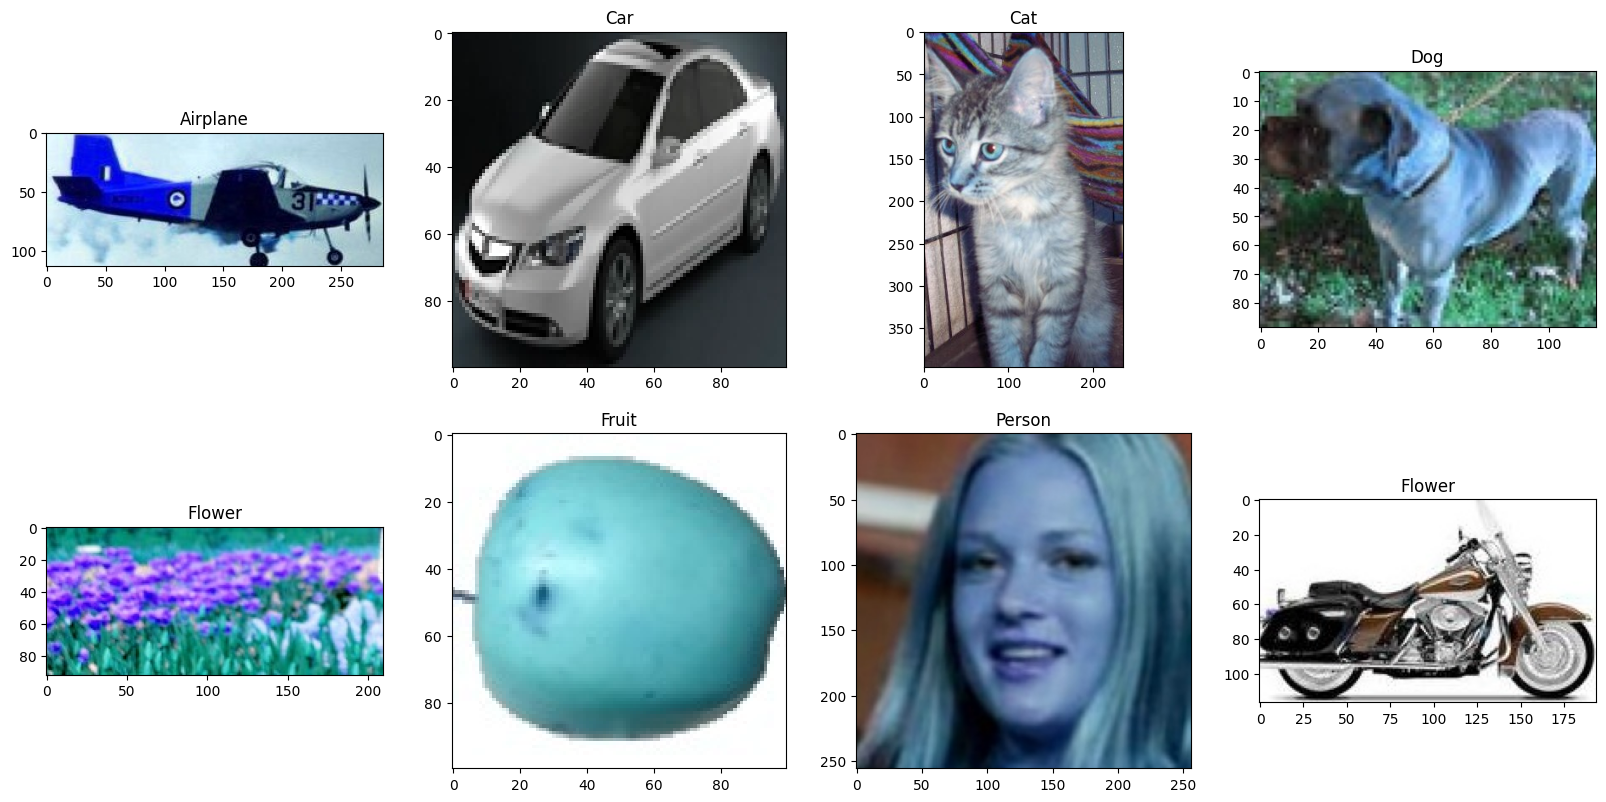

In [80]:
# se extraen algunos ejemplos del conjunto de imagenes

plt.figure(figsize=(20,20))

plt.subplot(4, 4, 1)
plt.title('Airplane')
plt.imshow(cv2.imread(f'{images_path}/airplane/airplane_0001.jpg'))

plt.subplot(4, 4, 2)
plt.title('Car')
plt.imshow(cv2.imread(f'{images_path}/car/car_0001.jpg'))

plt.subplot(4, 4, 3)
plt.title('Cat')
plt.imshow(cv2.imread(f'{images_path}/cat/cat_0000.jpg'))

plt.subplot(4, 4, 4)
plt.title('Dog')
plt.imshow(cv2.imread(f'{images_path}/dog/dog_0000.jpg'))

plt.subplot(4, 4, 5)
plt.title('Flower')
plt.imshow(cv2.imread(f'{images_path}/flower/flower_0000.jpg'))

plt.subplot(4, 4, 6)
plt.title('Fruit')
plt.imshow(cv2.imread(f'{images_path}/fruit/fruit_0000.jpg'))

plt.subplot(4, 4, 7)
plt.title('Person')
plt.imshow(cv2.imread(f'{images_path}/person/person_0000.jpg'))

plt.subplot(4, 4, 8)
plt.title('Flower')
plt.imshow(cv2.imread(f'{images_path}/motorbike/motorbike_0000.jpg'))

plt.show()

In [81]:
# se procesan los archivos dentro de las subcarpetas, a fin de conocer, el nombre de la categoria de archivos en 
# cada subcarpeta, así como para realizar el conteo de elementos-archivos en cada una de las categorías.

filepaths=[]
labels=[]
classlist=os.listdir(images_path)
for klass in classlist:
    classpath=os.path.join(images_path,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)

Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print('distribucion de los datos'.center(60,'-'))
print (df['labels'].value_counts())

                                           filepaths labels
0  /Users/josemorenoc/Documents/1_Maestria MISIS/...    cat
1  /Users/josemorenoc/Documents/1_Maestria MISIS/...    cat
2  /Users/josemorenoc/Documents/1_Maestria MISIS/...    cat
3  /Users/josemorenoc/Documents/1_Maestria MISIS/...    cat
4  /Users/josemorenoc/Documents/1_Maestria MISIS/...    cat
-----------------distribucion de los datos------------------
labels
fruit        1000
person        986
car           968
cat           885
flower        843
motorbike     788
airplane      727
dog           702
Name: count, dtype: int64


In [82]:
# Manejo desbalance de los datos: 
# para lograr tener el mismo tamaño de muestras para todas las categorías, se seleccionara de forma aleatoria de cada categoria,
# aquel número de elementos que es igual al mínimo de todas las categorías. 

# Se crea la tabla con conteo de elementos por categoría
tabla_conteo = df.groupby('labels').size().reset_index(name='conteo')

# se obtiene el valor
valor_minimo = tabla_conteo['conteo'].min()

print(tabla_conteo)
print("El valor mínimo de los elementos en la columna 'conteo' es:", valor_minimo)


      labels  conteo
0   airplane     727
1        car     968
2        cat     885
3        dog     702
4     flower     843
5      fruit    1000
6  motorbike     788
7     person     986
El valor mínimo de los elementos en la columna 'conteo' es: 702


In [83]:
# Se realiza la selección aleatoria del mínimo de elementos de las categorias:

fruit_df = shuffle(df.loc[df['labels'] == 'fruit']).head(valor_minimo).reset_index(drop=True)
person_df = shuffle(df.loc[df['labels'] == 'person']).head(valor_minimo).reset_index(drop=True)
car_df = shuffle(df.loc[df['labels'] == 'car']).head(valor_minimo).reset_index(drop=True)
cat_df = shuffle(df.loc[df['labels'] == 'cat']).head(valor_minimo).reset_index(drop=True)
flower_df = shuffle(df.loc[df['labels'] == 'flower']).head(valor_minimo).reset_index(drop=True)
motorbike_df = shuffle(df.loc[df['labels'] == 'motorbike']).head(valor_minimo).reset_index(drop=True)
airplane_df = shuffle(df.loc[df['labels'] == 'airplane']).head(valor_minimo).reset_index(drop=True)
dog_df = shuffle(df.loc[df['labels'] == 'dog']).head(valor_minimo).reset_index(drop=True)

print(fruit_df.shape, person_df.shape, car_df.shape, cat_df.shape, flower_df.shape, motorbike_df.shape, airplane_df.shape, dog_df.shape)

(702, 2) (702, 2) (702, 2) (702, 2) (702, 2) (702, 2) (702, 2) (702, 2)


In [84]:
# a continuación, se unificará en un solo arreglo, toda la información de las diferentes categorias:
balanced_df = pd.concat([fruit_df, person_df, car_df, cat_df, flower_df, motorbike_df, airplane_df, dog_df], ignore_index=True)
balanced_df = shuffle(balanced_df).reset_index(drop = True)
balanced_df.head()

,filepaths,labels
0,/Users/josemorenoc/Documents/1_Maestria MISIS/...,fruit
1,/Users/josemorenoc/Documents/1_Maestria MISIS/...,car
2,/Users/josemorenoc/Documents/1_Maestria MISIS/...,flower
3,/Users/josemorenoc/Documents/1_Maestria MISIS/...,fruit
4,/Users/josemorenoc/Documents/1_Maestria MISIS/...,flower


## 1.1. División del dataset en particiones de entrenamiento, validación y testing.

In [85]:
# En este paso, se segmenta la muestra en los conjuntos de entrenamiento, test y validación:

X_train, X_test, y_train, y_test = train_test_split(balanced_df['filepaths'], balanced_df['labels'], test_size=0.30, random_state=33)

X_test, X_val, y_test, y_val= train_test_split(X_test, y_test, train_size=0.5, random_state=34)

## Preprocesamiento de los datos

In [86]:
# Se aplica la función previamente definida, para el preprocesamiento de archivos de imagenes.
X_train = preprocessing_data(X_train)
X_val = preprocessing_data(X_val)


In [87]:
# se codifican las etiquetas, y se llevan de cadenas de texto a valores númericos.
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

y_train = to_categorical(y_train, num_classes=8)
y_val = to_categorical(y_val, num_classes=8)

## 1.2. Arquitectura de red neuronal densa con al menos 3 capas.


In [88]:
# se utilizará un callback para evitar el sobre-ajuste y lograr optimizar el tiempo y no tener tiempos ociosos o perdidos, 
# si el algoritmo inicial no converge.. 

# conn esta configuración, el algoritmo se detendrá, cuando la pérdida en el conjunto de validación no disminuya.
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)


In [89]:
# Se procede a formular el modelo de redes densas:

from tensorflow.keras.layers import Input

model_base = tf.keras.models.Sequential([
  Input(shape=(IMG_SIZE, IMG_SIZE, 1)),  # acá se indica que cada muestra de datos de entrada,
                                         # es una imagen en escala de grises de tamaño IMG_SIZE
  Flatten(),
                                         # linea previa:    Flatten(input_shape =(IMG_SIZE,IMG_SIZE,1)),
  Dense(400, activation='relu'),
  Dropout(0.15),

  Dense(200, activation='relu'),
  Dropout(0.15),

  Dense(100, activation='relu'),
  Dropout(0.15),
    
  Dense(8, activation='softmax')         # Se fijan 8 capas, dado que se caracterizaran 8 categorias; además con la 
                                         # función de activación 'softmax' que se utiliza en la capa de salida, se convierten 
                                         # las salidas en probabilidades. Esto es útil en problemas de clasificación multiclase, 
                                         # ya que produce una distribución de probabilidad sobre las clases, lo que significa que 
                                         # la suma de todas las probabilidades es igual a 1.
])

 


In [90]:
# Se procede a compilar el modelo planteado y a parametrizarlo:

model_base.compile(
    optimizer='adam',  # el optimizador Adam es de uso comun por su eficiencia para estos modelos de RN; este algoritmo
                       # ajusta automáticamente la tasa de aprendizaje durante el entrenamiento y generalmente converge 
                       # más rápido que otros optimizadores tradicionales como el Descenso del Gradiente Estocástico (SGD).
    loss=tf.keras.losses.CategoricalCrossentropy(),  # para la función de pérdida en este caso se utilizará la entropía cruzada categórica
                                                     # que es una función de pérdida comúnmente utilizada en problemas de clasificación 
                                                    # multiclase donde las etiquetas se han codificado de forma one-hot.
    metrics=['accuracy']   # con la métrica de precisión, se calcula la proporción de predicciones correctas 
                           # en relación con el total de muestras.
)

In [91]:
model_base.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 59536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 400)            │    23,814,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 200)            │        80,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 8)              │           808 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,915,908 (91.23 MB)

 Trainable params: 23,915,908 (91.23 MB)

 Non-trainable params: 0 (0.00 B)

In [92]:
history_base = model_base.fit(X_train, y_train, validation_data= (X_val, y_val), batch_size=128, epochs = 200, callbacks=[early])

Epoch 1/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.1701 - loss: 9.4886 - val_accuracy: 0.3464 - val_loss: 1.6719
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.3433 - loss: 1.8068 - val_accuracy: 0.5148 - val_loss: 1.3865
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.4712 - loss: 1.4952 - val_accuracy: 0.5540 - val_loss: 1.2487
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.4925 - loss: 1.3937 - val_accuracy: 0.5836 - val_loss: 1.1605
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.5300 - loss: 1.2743 - val_accuracy: 0.5694 - val_loss: 1.1491
Epoch 6/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.5400 - loss: 1.2642 - val_accuracy: 0.6180 - val_loss: 1.0440
Epoch 7/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.5634 - loss: 1.1983 - val_accuracy: 0.6145 - val_loss: 1.0977
Epoch 8/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.5798 - loss: 1.1348 - val_accur

##  1.3 Curvas de loss vs epoch para los sets de entrenamiento y validación.


<Axes: xlabel='epochs', ylabel='accuracy'>

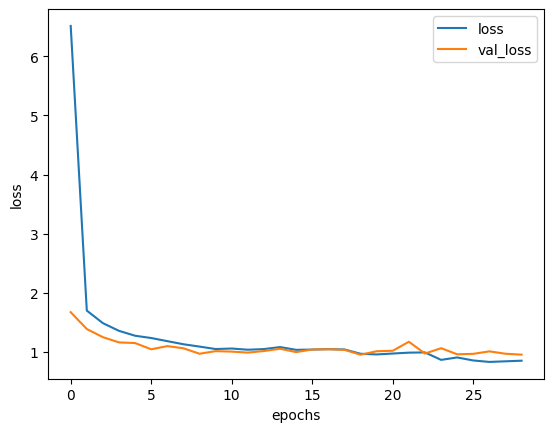

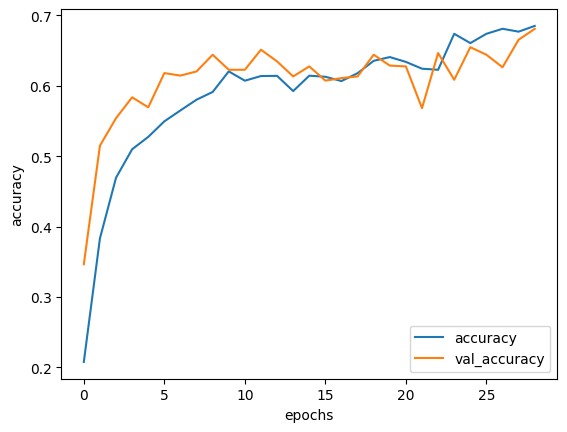

In [93]:
df = pd.DataFrame(history_base.history)
df.plot(y=['loss', 'val_loss'], xlabel='epochs', ylabel='loss')

df = pd.DataFrame(history_base.history)
df.plot(y=['accuracy', 'val_accuracy'], xlabel='epochs', ylabel='accuracy')

In [ ]:
# Según estos resultados obtenidos, el modelo se comporta en términos generales, bastante bien, en términos de no presentar sobreajuste
# Sin embargo, como se verá más adelante, en las medidas de precisión, sensibiliodad y de ajuste global, 
# se podría pensar que el poder predictivo es relativamente bajo.
# 

## 1.4 Deploy del modelo

In [94]:
model_base.save('./model_base.h5')

In [95]:
X_test= preprocessing_data(X_test)
y_test = le.transform(y_test)
y_test = to_categorical(y_test)

In [96]:
y_pred_base = model_base.predict(X_test)
y_pred_base = y_pred_base.argmax(axis=-1)

print('Ejemplo predicción: ', y_pred_base[0])
print('Ejemplo valor real: ', y_test[0].argmax(axis=-1))

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Ejemplo predicción:  4
Ejemplo valor real:  3


## 1.5 Reporte de resultados

In [97]:
score = model_base.evaluate(X_test, y_test, verbose=1)
print(f'Test loss: {score[0]}\nTest Accuracy: {score[1]}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6810 - loss: 0.8511
Test loss: 0.8519898653030396
Test Accuracy: 0.6710214018821716


In [98]:
Y_test = y_test.argmax(axis=-1)

print('Reporte para el modelo sin convolucion'.center(60,'-'))
print(classification_report(Y_test, y_pred_base, target_names=['fruit', 'person', 'car', 'cat', 'flower', 'motorbike', 'airplane', 'dog']))
model_base_report = classification_report(Y_test, y_pred_base, target_names=['fruit', 'person', 'car', 'cat', 'flower', 'motorbike', 'airplane', 'dog'], output_dict=True)



-----------Reporte para el modelo sin convolucion-----------
              precision    recall  f1-score   support

       fruit       0.79      0.74      0.76       107
      person       0.84      0.72      0.77       107
         car       0.50      0.50      0.50       123
         cat       0.37      0.10      0.16       102
      flower       0.33      0.60      0.42        99
   motorbike       0.85      0.99      0.91       102
    airplane       0.89      0.83      0.86       102
         dog       0.88      0.93      0.90       100

    accuracy                           0.67       842
   macro avg       0.68      0.68      0.66       842
weighted avg       0.68      0.67      0.66       842



In [ ]:
# Como se anticipo un poco, las medidas de precisión, sensibiliodad y de ajuste global del modelo, se podrían considerar relativamentes bajas
# del orden del 66%. sin embargo el modelo no presente sobreajuste, y tendria una capacidad de generalización aceptable. 
#
#

## Punto 2: Clasificación de imágenes con ConvNets

Requerimientos básicos:
- Contruir una red convolucional de al menos 3 capas convolucionales. Utilice las mismas particiones del punto 1.
- Guardar el modelo proveniente de la red convolucional.
- Hacer deploy del modelo (realizar prediccion sobre una imagen dada).
- De ser necesario realizar estrategias de aumentación de datos

## Punto 2.1. Red Convolucional con al menos 3 capas convnets.

In [103]:
# Se procede a formular el modelo de redes densas:

from tensorflow.keras.layers import Input

model_base_cv = tf.keras.models.Sequential([
  Input(shape=(IMG_SIZE, IMG_SIZE, 1)),
  Conv2D(30, kernel_size=(3,3), activation='relu'),
  MaxPooling2D(),

  Conv2D(20, kernel_size=(3,3), activation='relu'),
  MaxPooling2D(),

  Conv2D(20, kernel_size=(3,3), activation='relu'),
  MaxPooling2D(),

  Flatten(),
  Dense(64, activation='relu'),
  Dropout(0.15),
  Dense(8, activation='softmax')
])

# se establece el callback:
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)


In [104]:
# Se procede a compilar el modelo planteado y a parametrizarlo:

model_base_cv.compile(
    optimizer='adam',  # el optimizador Adam es de uso comun por su eficiencia para estos modelos de RN; este algoritmo
                       # ajusta automáticamente la tasa de aprendizaje durante el entrenamiento y generalmente converge 
                       # más rápido que otros optimizadores tradicionales como el Descenso del Gradiente Estocástico (SGD).
    loss=tf.keras.losses.CategoricalCrossentropy(),  # para la función de pérdida en este caso se utilizará la entropía cruzada categórica
                                                     # que es una función de pérdida comúnmente utilizada en problemas de clasificación 
                                                    # multiclase donde las etiquetas se han codificado de forma one-hot.
    metrics=['accuracy']   # con la métrica de precisión, se calcula la proporción de predicciones correctas 
                           # en relación con el total de muestras.
)

# 2.2 Se guarda el modelo:

In [105]:
# se revisa la caracterización del modelo:
model_base_cv.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 242, 242, 30)   │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 121, 121, 30)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 119, 119, 20)   │         5,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 59, 59, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 57, 57, 20)     │         3,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 15680)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │     1,003,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,013,444 (3.87 MB)

 Trainable params: 1,013,444 (3.87 MB)

 Non-trainable params: 0 (0.00 B)

In [106]:
history_base_cv = model_base_cv.fit(X_train, y_train, validation_data= (X_val, y_val), batch_size=60, epochs = 20, callbacks=[early])

Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 23s 321ms/step - accuracy: 0.4044 - loss: 1.5956 - val_accuracy: 0.7414 - val_loss: 0.7319
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 291ms/step - accuracy: 0.7545 - loss: 0.6621 - val_accuracy: 0.7829 - val_loss: 0.5946
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 309ms/step - accuracy: 0.8437 - loss: 0.4357 - val_accuracy: 0.8114 - val_loss: 0.4965
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 292ms/step - accuracy: 0.8747 - loss: 0.3287 - val_accuracy: 0.8138 - val_loss: 0.5047
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 289ms/step - accuracy: 0.9022 - loss: 0.2565 - val_accuracy: 0.8268 - val_loss: 0.4509
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 289ms/step - accuracy: 0.9319 - loss: 0.1856 - val_accuracy: 0.8185 - val_loss: 0.5062
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 289ms/step - accuracy: 0.9501 - loss: 0.1424 - val_accuracy: 0.8351 - val_loss: 0.5401
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 299ms/step - accuracy: 0.9578 - loss: 0.1231 - val_accu

##  2.3 Curvas de loss vs epoch para los sets de entrenamiento y validación (Modelo ConvNets)

<Axes: xlabel='epochs', ylabel='accuracy'>

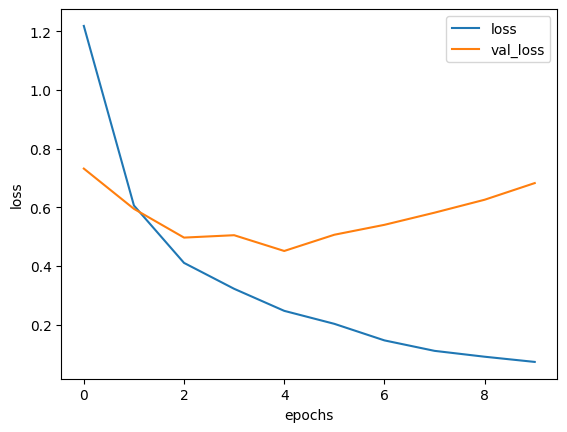

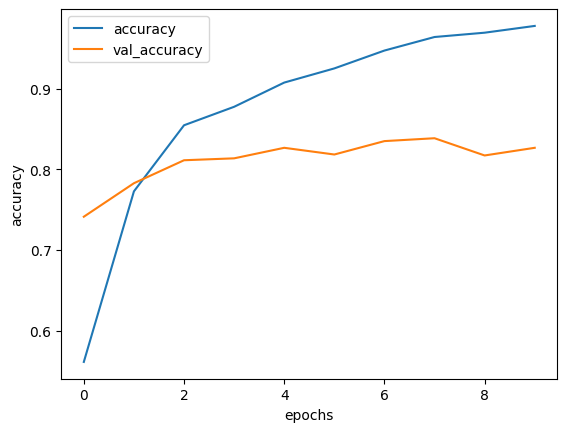

In [107]:
df_cv = pd.DataFrame(history_base_cv.history)
df_cv.plot(y=['loss', 'val_loss'], xlabel='epochs', ylabel='loss')

df_cv = pd.DataFrame(history_base_cv.history)
df_cv.plot(y=['accuracy', 'val_accuracy'], xlabel='epochs', ylabel='accuracy')

In [ ]:
# Según estos resultados obtenidos, el modelo se comporta en términos generales, con problemas de sobreajuste, por lo cual
# su capacidad de caracterización es limitada.
# Sin embargo, como se verá más adelante, en las medidas de precisión, sensibiliodad y de ajuste global, 
# se podría pensar que el poder predictivo bastante bueno; pero estos resultados, deberían tomarse con reserva.
# 

In [118]:
# se guarda el modelo con convoluciones:
model_base_cv.save('./model_base_cv.h5')


In [109]:
y_pred_base_cv = model_base_cv.predict(X_test)
y_pred_base_cv = y_pred_base_cv.argmax(axis=-1)

print('Ejemplo predicción: ', y_pred_base_cv[0])
print('Ejemplo valor real: ', y_test[0].argmax(axis=-1))


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step
Ejemplo predicción:  3
Ejemplo valor real:  3


In [110]:
score_cv = model_base_cv.evaluate(X_test, y_test, verbose=1)
print(f'Test loss: {score_cv[0]}\nTest Accuracy: {score_cv[1]}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8256 - loss: 0.6900
Test loss: 0.6409889459609985
Test Accuracy: 0.8384798169136047


## 2.4 Reporte de resultados (Modelo ConvNets)

In [115]:
Y_test = y_test.argmax(axis=-1)

print('Reporte para el modelo CON convolucion'.center(60,'-'))
print(classification_report(Y_test, y_pred_base_cv, target_names=['fruit', 'person', 'car', 'cat', 'flower', 'motorbike', 'airplane', 'dog']))
model_base_report_cv = classification_report(Y_test, y_pred_base_cv, target_names=['fruit', 'person', 'car', 'cat', 'flower', 'motorbike', 'airplane', 'dog'], output_dict=True)


-----------Reporte para el modelo CON convolucion-----------
              precision    recall  f1-score   support

       fruit       0.96      0.92      0.94       107
      person       0.93      0.93      0.93       107
         car       0.74      0.54      0.63       123
         cat       0.56      0.74      0.64       102
      flower       0.67      0.69      0.68        99
   motorbike       0.99      1.00      1.00       102
    airplane       0.94      0.98      0.96       102
         dog       0.99      0.97      0.98       100

    accuracy                           0.84       842
   macro avg       0.85      0.84      0.84       842
weighted avg       0.85      0.84      0.84       842



## Punto 3: Comparación entre modelos ajustados

Compare los modelos, cual se comporto mejor?, por qué?

In [119]:
# Arreglos con los 2 modelos ajustados:
# model_base_report 
# model_base_report_cv
#

data = {
    'Model': ['Modelo sin convolución', 'Modelo con convolución'],
    'Accuracy': [
      model_base_report['macro avg']['precision'],
      model_base_report_cv['macro avg']['precision'],
    ],
    'Recall': [
      model_base_report['macro avg']['recall'],
      model_base_report_cv['macro avg']['recall']
    ],
    'F1 Score': [
      model_base_report['macro avg']['f1-score'],
      model_base_report_cv['macro avg']['f1-score']
    ]
}

df_result = pd.DataFrame(data)
df_result.set_index('Model', inplace=True)
df_result.sort_values(by=['F1 Score'],ascending=False)

,Accuracy,Recall,F1 Score
Model,,,
Modelo con convolución,0.847342,0.844799,0.842657
Modelo sin convolución,0.679298,0.675176,0.661014


In [116]:
# Se concluye que el modelo con convolución presenta mejores resultados de precisión, sensibilidad y ajuste general;
# Sin embargo, en las gráficas de ajuste, se encontró que el modelo con convolución, tiende a sobreajustarse, por lo cual,
# más allá de estos resultados, se debería tomar con precaución el ajuste logrado con dicho modelo.


